# Lion
$g_t = \nabla_\theta f(\theta_{t-1})$

$c_t = \beta_1 m_{t-1} + (1-\beta_1) g_t$

$\theta_t = \theta_{t-1} - \eta (\text{sign}(c_t) + \lambda \theta_{t-1})$

$m_t = \beta_2 m_{t-1} + (1-\beta_2) g_t$

Lion paper: https://arxiv.org/pdf/2302.06675

$\beta_1 = 0.9, \ \beta_2 = 0.99$

### AdamW
$g_t = \nabla_\theta f(\theta_{t-1})$

$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$

$v_t = \beta_2 v_{t-1} + (1 - \beta_2) v_t$

$\hat m_t = m_t / (1 - \beta_1 ^ t)$

$\hat v_t = v_t / (1 - \beta_2 ^ t)$

$\theta_t = (1 - \lambda) \theta_{t-1} - \eta \hat m_t / (\sqrt{\hat v_t} + \epsilon)$

Unlike AdamW, Lion doesn't estimate the second moment (and saves optimizer space). AdamW updates with $m / \sqrt{v}$, normalizing the running mean of the gradients by the square root of the second moment to yield ~unit pre-lr updates.

Instead of normalizing by the second moment, Lion just uses the sign of the mean gradient so that updates are exactly size lr.

Lion uses 2 linear interpolations for the 1st moment (see Section 4.6 in the paper). Using a $\beta_1 < \beta_2$ allows the update to use the current gradient more, while keeping more long-term historical information in the running mean.

The authors note (Section 5) that Lion requires a ~10x smaller learning rate compared to AdamW. Emprically I see that AdamW pre-lr updates (at least for this toy example) are ~0.1 so that could make sense.

The authors say (Section 4.6) that Lion benefits from larger batch sizes to counteract noise from the sign operation.

In [1]:
import torch

class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    @torch.no_grad()
    def zero_grad(self):
        for p in self.parameters:
            p.grad = None

In [2]:
class Lion(Optimizer):
    def __init__(self, parameters, lr: float = 1e-4, weight_decay: float = 0, betas: tuple[float, float] = (0.9, 0.99)):
        super().__init__(parameters)
        self.lr = lr
        self.weight_decay = weight_decay
        self.betas = betas
        self.mean_grads = [torch.zeros_like(p, requires_grad=False) for p in self.parameters]

        self.hist_names = ("param", "update_ratio")
        self.hist = {name: [[] for _ in self.parameters] for name in self.hist_names}

    @torch.no_grad()
    def step(self):
        for i, p in enumerate(self.parameters):
            g = p.grad.detach().clone()
            c = self.betas[0]*self.mean_grads[i] + (1-self.betas[0])*g
            if self.weight_decay > 0:
                p -= self.weight_decay * p
            u = c.sign()
            p -= self.lr * u
            self.mean_grads[i] = self.betas[1]*self.mean_grads[i] + (1-self.betas[1])*g

            for name, t in zip(self.hist_names, (p, (self.lr * u) / p)):
                self.hist[name][i].append(t.abs().mean().item())

0: loss=0.166644, acc=0.937500
1: loss=0.038966, acc=0.992188


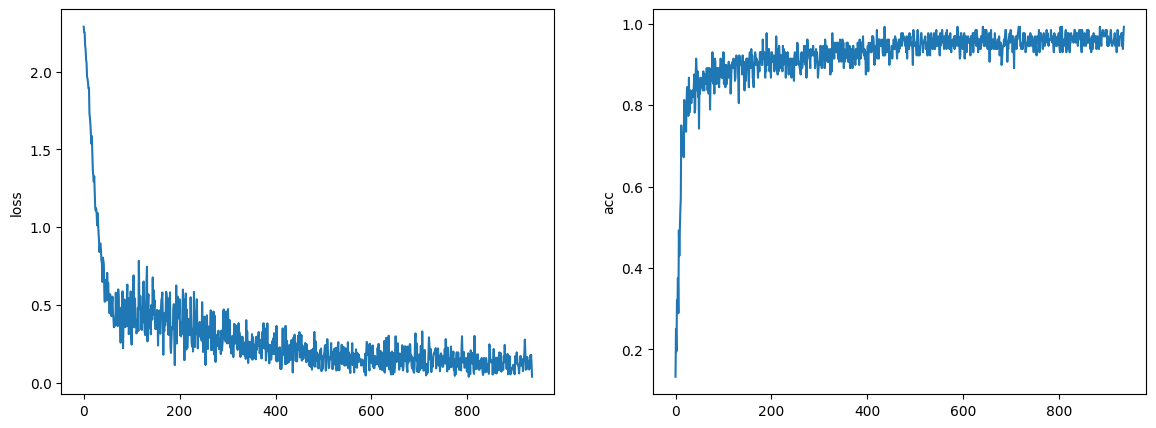

In [3]:
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import v2
import matplotlib.pyplot as plt

@torch.no_grad()
def calc_acc(logits: torch.Tensor, target: torch.Tensor) -> float:
    return (logits.argmax(dim=-1) == target).to(dtype=torch.float32).mean().item()

transform = v2.Compose([v2.ToImage(), v2.ToDtype(dtype=torch.float32, scale=True)])
train_ds = MNIST("data", train=True, transform=transform, download=True)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

model = nn.Sequential(nn.Flatten(), nn.Linear(784, 64), nn.ReLU(), nn.Linear(64, 10)).to("cuda")
optim = Lion(model.parameters(), lr=1e-3, weight_decay=1e-5, betas=(0.9, 0.99))

losses, accs = [], []
for epoch in range(2):
    for x, y in train_dl:
        x, y = x.to("cuda"), y.to("cuda")
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())
        accs.append(calc_acc(logits, y))
    print(f"{epoch}: loss={losses[-1]:.6f}, acc={accs[-1]:.6f}")

_, (loss_ax, acc_ax) = plt.subplots(ncols=2, figsize=(14, 5))
loss_ax.plot(losses)
loss_ax.set_ylabel("loss")
acc_ax.plot(accs)
acc_ax.set_ylabel("acc")
plt.show()

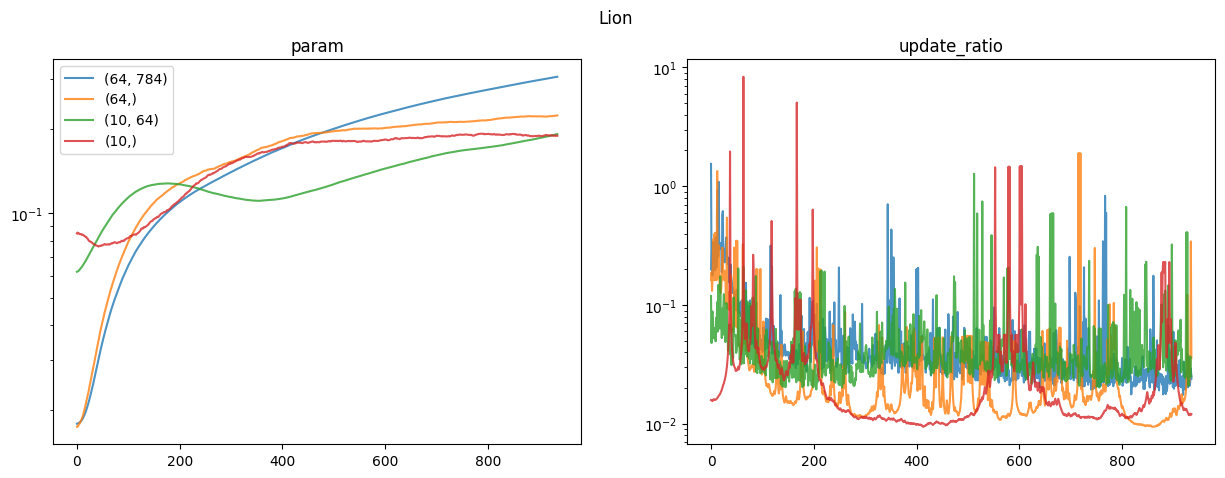

In [4]:
fig, axs = plt.subplots(ncols=len(optim.hist), figsize=(15, 5))
for ax, name in zip(axs.flat, optim.hist.keys()):
    t = torch.tensor(optim.hist[name])
    for i in range(t.shape[0]):
        ax.plot(t[i], label=str(tuple(optim.parameters[i].shape)), alpha=0.8)
        ax.set_yscale("log")
    ax.set_title(name)
    if name == "param":
        ax.legend(loc=0)
fig.suptitle("Lion")
plt.show()